<a href="https://colab.research.google.com/github/caleb-vicente/RL_tutorials/blob/dev/Traveling_Salesman_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   We are following the tutorial of page: https://ekimetrics.github.io/blog/2021/11/03/tsp/
*   How to create a new gym environment: https://towardsdatascience.com/beginners-guide-to-custom-environments-in-openai-s-gym-989371673952
*   Whole solution to the problem can be found here: https://github.com/TheoLvs/reinforcement-learning/blob/master/5.%20Delivery%20Optimization/Optimizing%20delivery%20with%20Reinforcement%20Learning.ipynb
*   En OR-gym tenemos un entorno ya generado para TSP: https://github.com/hubbs5/or-gym

In [ ]:
!pip install gymnasium==0.26.1
!pip install "ray[rllib]" torch
!pip install moviepy==1.0.3
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.4/830.4 kB 19.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.9/836.9 kB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 45.4 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.

In [ ]:
# import os

# def remove_files_and_dirs(directory):
#     for root, dirs, files in os.walk(directory, topdown=False):
#         for file in files:
#             os.remove(os.path.join(root, file))
#         for dir in dirs:
#             os.rmdir(os.path.join(root, dir))
#     os.rmdir(directory)

# remove_files_and_dirs('/content/results/DQN')

## Create Simple Environment

In [ ]:
# ===============================================================================================================================================
# This enviroment has been obtained from: https://github.com/TheoLvs/reinforcement-learning/blob/master/5.%20Delivery%20Optimization/delivery.py
# ===============================================================================================================================================

# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
import imageio
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

plt.style.use("seaborn-dark")

class DeliveryEnvironment(object):
    def __init__(self,n_stops = 10,max_box = 10,method = "distance",**kwargs):

        # Initialization
        self.n_stops = n_stops
        self.action_space = self.n_stops
        self.observation_space = self.n_stops
        self.max_box = max_box
        self.stops = []
        self.method = method
        self.first_stop = None

        # Generate stops
        self._generate_constraints(**kwargs)
        self._generate_stops()
        self._generate_q_values()
        #self.render()

        # Initialize first point
        self.reset()


    def _generate_constraints(self,box_size = 0.2,traffic_intensity = 5):

        if self.method == "traffic_box":

            x_left = np.random.rand() * (self.max_box) * (1-box_size)
            y_bottom = np.random.rand() * (self.max_box) * (1-box_size)

            x_right = x_left + np.random.rand() * box_size * self.max_box
            y_top = y_bottom + np.random.rand() * box_size * self.max_box

            self.box = (x_left,x_right,y_bottom,y_top)
            self.traffic_intensity = traffic_intensity 



    def _generate_stops(self):

        if self.method == "traffic_box":

            points = []
            while len(points) < self.n_stops:
                x,y = np.random.rand(2)*self.max_box
                if not self._is_in_box(x,y,self.box):
                    points.append((x,y))

            xy = np.array(points)

        else:
            # Generate geographical coordinates
            xy = np.random.rand(self.n_stops,2)*self.max_box

        self.x = xy[:,0]
        self.y = xy[:,1]


    def _generate_q_values(self,box_size = 0.2):

        # Generate actual Q Values corresponding to time elapsed between two points
        if self.method in ["distance","traffic_box"]:
            xy = np.column_stack([self.x,self.y])
            self.q_stops = cdist(xy,xy)
        elif self.method=="time":
            self.q_stops = np.random.rand(self.n_stops,self.n_stops)*self.max_box
            np.fill_diagonal(self.q_stops,0)
        else:
            raise Exception("Method not recognized")
    

    def render(self,return_img = False):
        
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        ax.set_title("Delivery Stops")

        # Show stops
        ax.scatter(self.x,self.y,c = "red",s = 50)

        # Show START
        if len(self.stops)>0:
            xy = self._get_xy(initial = True)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("START",xy=xy,xytext=xytext,weight = "bold")

        # Show itinerary
        if len(self.stops) > 1:
            ax.plot(self.x[self.stops],self.y[self.stops],c = "blue",linewidth=1,linestyle="--")
            
            # Annotate END
            xy = self._get_xy(initial = False)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("END",xy=xy,xytext=xytext,weight = "bold")


        if hasattr(self,"box"):
            left,bottom = self.box[0],self.box[2]
            width = self.box[1] - self.box[0]
            height = self.box[3] - self.box[2]
            rect = Rectangle((left,bottom), width, height)
            collection = PatchCollection([rect],facecolor = "red",alpha = 0.2)
            ax.add_collection(collection)


        plt.xticks([])
        plt.yticks([])
        
        if return_img:
            # From https://ndres.me/post/matplotlib-animated-gifs-easily/
            fig.canvas.draw_idle()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close()
            return image
        else:
            plt.show()



    def reset(self):

        # Stops placeholder
        self.stops = []

        # Random first stop
        self.first_stop = np.random.randint(self.n_stops)
        self.stops.append(self.first_stop)

        return self.first_stop


    def step(self,destination):

        # Get current state
        state = self._get_state()
        new_state = destination

        # Get reward for such a move
        reward = self._get_reward(state,new_state)

        # Append new_state to stops
        self.stops.append(destination)
        done = len(self.stops) == self.n_stops

        return new_state,-reward,done
    

    def _get_state(self):
        return self.stops[-1]


    def _get_xy(self,initial = False):
        state = self.stops[0] if initial else self._get_state()
        x = self.x[state]
        y = self.y[state]
        return x,y


    def _get_reward(self,state,new_state):
        base_reward = self.q_stops[state,new_state]

        if self.method == "distance":
            return base_reward
        elif self.method == "time":
            return base_reward + np.random.randn()
        elif self.method == "traffic_box":

            # Additional reward correspond to slowing down in traffic
            xs,ys = self.x[state],self.y[state]
            xe,ye = self.x[new_state],self.y[new_state]
            intersections = self._calculate_box_intersection(xs,xe,ys,ye,self.box)
            if len(intersections) > 0:
                i1,i2 = intersections
                distance_traffic = np.sqrt((i2[1]-i1[1])**2 + (i2[0]-i1[0])**2)
                additional_reward = distance_traffic * self.traffic_intensity * np.random.rand()
            else:
                additional_reward = np.random.rand()

            return base_reward + additional_reward


    @staticmethod
    def _calculate_point(x1,x2,y1,y2,x = None,y = None):

        if y1 == y2:
            return y1
        elif x1 == x2:
            return x1
        else:
            a = (y2-y1)/(x2-x1)
            b = y2 - a * x2

            if x is None:
                x = (y-b)/a
                return x
            elif y is None:
                y = a*x+b
                return y
            else:
                raise Exception("Provide x or y")


    def _is_in_box(self,x,y,box):
        # Get box coordinates
        x_left,x_right,y_bottom,y_top = box
        return x >= x_left and x <= x_right and y >= y_bottom and y <= y_top


    def _calculate_box_intersection(self,x1,x2,y1,y2,box):

        # Get box coordinates
        x_left,x_right,y_bottom,y_top = box

        # Intersections
        intersections = []

        # Top intersection
        i_top = self._calculate_point(x1,x2,y1,y2,y=y_top)
        if i_top > x_left and i_top < x_right:
            intersections.append((i_top,y_top))

        # Bottom intersection
        i_bottom = self._calculate_point(x1,x2,y1,y2,y=y_bottom)
        if i_bottom > x_left and i_bottom < x_right:
            intersections.append((i_bottom,y_bottom))

        # Left intersection
        i_left = self._calculate_point(x1,x2,y1,y2,x=x_left)
        if i_left > y_bottom and i_left < y_top:
            intersections.append((x_left,i_left))

        # Right intersection
        i_right = self._calculate_point(x1,x2,y1,y2,x=x_right)
        if i_right > y_bottom and i_right < y_top:
            intersections.append((x_right,i_right))

        return intersections


<ipython-input-2-75c4af12c79a>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark")


# Create same environmet with gym

In [ ]:
import gymnasium
from gymnasium import spaces
import numpy as np
from sklearn.preprocessing import normalize

class DeliveryEnv(gymnasium.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, n_stops=10, max_box=10, method="distance", **kwargs):
        print('number of stops' + str(n_stops))
        self.n_stops = n_stops
        self.max_box = max_box
        self.method = method
        self.kwargs = kwargs
        self.delivery_env = DeliveryEnvironment(n_stops=n_stops, max_box=max_box, method=method, **kwargs)
        self.action_space = spaces.Discrete(n_stops)
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_stops * 4,), dtype=np.float32)
        self.state = None
        self.truncated = False
        self.terminated = False
        self.reward_episode = 0

    def step(self, action):
        
        if action in self.delivery_env.stops:
          reward = -50
          state = self.state
          self.truncated = True
        else: 
          state, reward, done = self.delivery_env.step(action)
        if len(self.delivery_env.stops) == self.n_stops:
          self.terminated = True

        self.state = state
        one_hot_state = self.one_hot_encode(state, self.n_stops)

        # Encode and normalize the positon of all the points
        points_normalized = np.concatenate((normalize([self.delivery_env.x]), normalize([self.delivery_env.y]))).flatten()

        self.reward_episode += reward     

        return np.concatenate((one_hot_state, points_normalized, self.stops_encoder())).flatten(), reward, self.terminated, self.truncated , {} 

    def reset(self, seed=None, options=None):
        self.delivery_env = DeliveryEnvironment(n_stops=self.n_stops, max_box=self.max_box, method=self.method, **self.kwargs)
        self.state = self.delivery_env.reset()
        one_hot_state = self.one_hot_encode(self.state, self.n_stops)

        # Encode and normalize the positon of all the points
        points_normalized = np.concatenate((normalize([self.delivery_env.x]), normalize([self.delivery_env.y]))).flatten()

        # Reset attributes
        self.reward_episode = 0
        self.truncated = False
        self.terminated = False


        return np.concatenate((one_hot_state, points_normalized, self.stops_encoder())).flatten(), {}

    def one_hot_encode(self, state, n_stops):
        one_hot = np.zeros(n_stops)
        one_hot[state] = 1
        return one_hot

    def stops_encoder(self):
      result = [1 if i in self.delivery_env.stops else 0 for i in range(self.n_stops)]
      return result

    def render(self, mode='human', close=False):
        return self.delivery_env.render(return_img=True)



In [ ]:
env = DeliveryEnv(n_stops=5, max_box=10, method="distance")

number of stops5


In [ ]:
env.delivery_env.stops

[0]

In [ ]:
env.action_space

Discrete(5)

In [ ]:
env.observation_space.shape

(15,)

In [ ]:
env.action_space.sample()

4

In [ ]:
env.step(2)

(array([0.        , 0.        , 1.        , 0.        , 0.        ,
        0.47391059, 0.40317757, 0.51610846, 0.35357471, 0.47060979,
        0.31747474, 0.48306511, 0.73553452, 0.34384813, 0.08133465,
        1.        , 0.        , 1.        , 0.        , 0.        ]),
 -4.684689907745888,
 False,
 False,
 {})

In [ ]:
env.delivery_env.first_stop

3

In [ ]:
env.observation_space

Box(0.0, 1.0, (15,), float32)

In [ ]:
env.reward_range

(-inf, inf)

In [ ]:
env.reset()

(array([1.        , 0.        , 0.        , 0.        , 0.        ,
        0.51227051, 0.41213361, 0.51738183, 0.52426772, 0.15869533,
        0.05100925, 0.45431721, 0.3509565 , 0.57893381, 0.57676607]),
 {})

## Training algorithm RL 

In [ ]:
import ray

ray.init(num_cpus=3, ignore_reinit_error=True, log_to_driver=False)

2023-04-29 19:13:39,267	INFO worker.py:1625 -- Started a local Ray instance.


Python version:,3.10.11
Ray version:,2.4.0


### Custom model

In [ ]:
# Create custom model
import torch
import torch.nn as nn
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.utils import override

# Custom Model
class CustomDQNModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)
       
        input_size = obs_space.shape[0]
        print('input size is ')
        print(input_size)
        self.input_layer = nn.Linear(input_size, input_size)
        self.hidden1 = nn.Linear(obs_space.shape[0], 256)
        self.hidden2 = nn.Linear(256, 256)
        self.output_layer = nn.Linear(256, num_outputs)

        # Add a separate output head for the value function
        self.value_output_layer = nn.Linear(256, 1)

    def forward(self, input_dict, state, seq_lens):
        x = input_dict["obs"].float()
        x = torch.tanh(self.input_layer(x))
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output_layer(x)

        # Compute the value function
        value = self.value_output_layer(x)
        
        return x, []

    @override(TorchModelV2)
    def value_function(self):
        return torch.reshape(self._value, [-1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
F

### Register model

In [ ]:
from ray.rllib.models import ModelCatalog

# Register the custom model
ModelCatalog.register_custom_model("custom_dqn_model", CustomDQNModel)

### Train custom model manual

In [ ]:
config.to_dict()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'extra_python_environs_for_driver': {},
 'extra_python_environs_for_worker': {},
 'num_gpus': 0,
 'num_cpus_per_worker': 1,
 'num_gpus_per_worker': 0,
 '_fake_gpus': False,
 'num_learner_workers': 0,
 'num_gpus_per_learner_worker': 0,
 'num_cpus_per_learner_worker': 1,
 'local_gpu_idx': 0,
 'custom_resources_per_worker': {},
 'placement_strategy': 'PACK',
 'eager_tracing': False,
 'eager_max_retraces': 20,
 'tf_session_args': {'intra_op_parallelism_threads': 2,
  'inter_op_parallelism_threads': 2,
  'gpu_options': {'allow_growth': True},
  'log_device_placement': False,
  'device_count': {'CPU': 1},
  'allow_soft_placement': True},
 'local_tf_session_args': {'intra_op_parallelism_threads': 8,
  'inter_op_parallelism_threads': 8},
 'env': 'DeliveryEnv-v0',
 'env_config': {'n_stops': 5},
 'observation_space': None,
 'action_space': None,
 'env_task_fn': None,
 'render_env': False,
 'clip_rewards': None,
 'normalize_actions': True,
 'clip_actions': False,
 'disable_env_checking': True,
 

In [ ]:
from ray.rllib.algorithms.dqn.dqn import DQNConfig
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print
from tqdm import tqdm

# Register the custom environment
def env_creator(env_config):
    return DeliveryEnv(n_stops=env_config['n_stops'])

register_env("DeliveryEnv-v0", env_creator)

config = DQNConfig()
config = config.environment(env='DeliveryEnv-v0', disable_env_checking=True, 
                           env_config={'n_stops': 5})
config = config.framework("torch").training(model={
   "custom_model": "custom_dqn_model"
}
)

algo = config.build()
episode_reward_mean_array = []

train_steps = 25
for i in tqdm(range(train_steps)):
    result = algo.train()
    print(result['episode_reward_mean'])
    episode_reward_mean_array.append(result['episode_reward_mean'])

    if i % 5 == 0:
        checkpoint_dir = algo.save()
        print(f"Checkpoint saved in directory {checkpoint_dir}")
    if i+1 == train_steps: 
        checkpoint_dir = algo.save()
        print(f"Checkpoint saved in directory {checkpoint_dir}")

2023-04-30 09:03:58,383	WARNING util.py:67 -- Install gputil for GPU system monitoring.


number of stops5
input size is 
20
input size is 
20


  4%|▍         | 1/25 [00:04<01:51,  4.65s/it]

-18.086088689527106
Checkpoint saved in directory /root/ray_results/DQN_DeliveryEnv-v0_2023-04-30_09-03-58qylvqbfl/checkpoint_000001


  8%|▊         | 2/25 [00:41<08:56, 23.33s/it]

-17.35496877589966


 12%|█▏        | 3/25 [01:22<11:35, 31.62s/it]

-18.244436402147564


 16%|█▌        | 4/25 [01:59<11:49, 33.80s/it]

-18.680907138585887


 20%|██        | 5/25 [02:39<11:56, 35.84s/it]

-20.041750753882777


 24%|██▍       | 6/25 [03:16<11:33, 36.50s/it]

-20.00386643302438
Checkpoint saved in directory /root/ray_results/DQN_DeliveryEnv-v0_2023-04-30_09-03-58qylvqbfl/checkpoint_000006


 28%|██▊       | 7/25 [03:57<11:18, 37.71s/it]

-19.308576827405485


 32%|███▏      | 8/25 [04:37<10:56, 38.64s/it]

-19.836716278793048


 36%|███▌      | 9/25 [05:18<10:27, 39.23s/it]

-19.993221867885573


 40%|████      | 10/25 [05:57<09:48, 39.24s/it]

-20.42890392765951


 44%|████▍     | 11/25 [06:40<09:23, 40.26s/it]

-19.753547761660165
Checkpoint saved in directory /root/ray_results/DQN_DeliveryEnv-v0_2023-04-30_09-03-58qylvqbfl/checkpoint_000011


 48%|████▊     | 12/25 [07:20<08:44, 40.34s/it]

-19.221402315475416


 52%|█████▏    | 13/25 [08:01<08:06, 40.51s/it]

-19.76590816927363


 56%|█████▌    | 14/25 [08:42<07:26, 40.58s/it]

-20.079697119450792


 60%|██████    | 15/25 [09:21<06:41, 40.11s/it]

-19.13301542407676


 64%|██████▍   | 16/25 [10:02<06:03, 40.34s/it]

-19.358047192751034
Checkpoint saved in directory /root/ray_results/DQN_DeliveryEnv-v0_2023-04-30_09-03-58qylvqbfl/checkpoint_000016


 68%|██████▊   | 17/25 [10:42<05:23, 40.46s/it]

-18.430389612760365


 68%|██████▊   | 17/25 [11:21<05:20, 40.09s/it]


KeyboardInterrupt: ignored

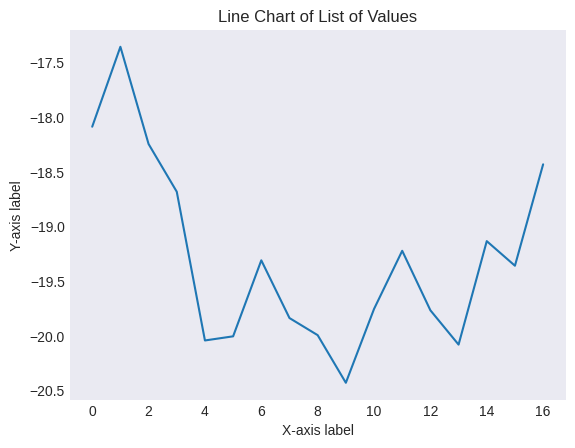

In [ ]:
import matplotlib.pyplot as plt

# Create a line chart
plt.plot(episode_reward_mean_array)

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Line Chart of List of Values')

# Display the chart
plt.show()


2023-04-30 09:16:27,841	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-04-30 09:16:27,883	INFO trainable.py:913 -- Restored on 172.28.0.12 from checkpoint: /root/ray_results/DQN_DeliveryEnv-v0_2023-04-30_09-03-58qylvqbfl/checkpoint_000016
2023-04-30 09:16:27,886	INFO trainable.py:922 -- Current state after restoring: {'_iteration': 16, '_timesteps_total': None, '_time_total': 601.4305005073547, '_episodes_total': 4789}


number of stops5
[0.         0.         0.         1.         0.         0.45687049
 0.32353394 0.69936862 0.26739739 0.35493282 0.03684123 0.83502272
 0.4569015  0.29779192 0.06277564 0.         0.         0.
 1.         0.        ]
number of stops5
input size is 
20
input size is 
20
action taken: 4
Episode reward: -3.036218795461441
[3, 4]
action taken: 2
Episode reward: -9.675739727862426
[3, 4, 2]
action taken: 1
Episode reward: -16.500004916448788
[3, 4, 2, 1]
action taken: 0
Episode reward: -26.150380519190705
[3, 4, 2, 1, 0]
terminated: True
truncated: False


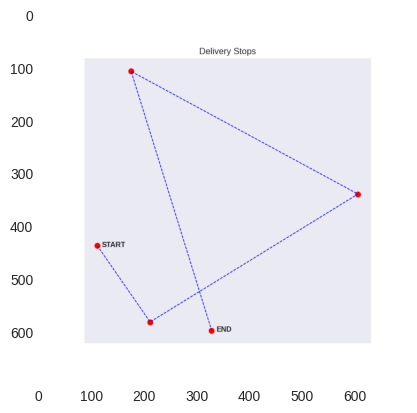

There are the stops used by the algorithm
Episode reward: -26.150380519190705


In [ ]:
episode_reward = 0
terminated = truncated = False

env = DeliveryEnv(n_stops=5, max_box=10, method="distance")

obs, info = env.reset()
print(obs)
frames = []  # Store frames for creating a video
stops = []

# Restore the trained model from the saved checkpoint
restored_algo = config.build()
restored_algo.restore(checkpoint_dir)

#while not terminated and not truncated:
for _ in range(4  ): # Longer episode than the one that gives a reward of 100
    action = restored_algo.compute_single_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    episode_reward = episode_reward + reward
    print('action taken: ' + str(action))
    print(f"Episode reward: {episode_reward}")
    print(env.delivery_env.stops)
    if terminated or truncated: 
      print('terminated: ' + str(terminated))
      print('truncated: ' + str(truncated))

frame = env.render()
plt.imshow(frame, cmap='gray')
plt.show()
string_stops = ','.join(map(str, stops))
print('There are the stops used by the algorithm' + string_stops)
env.close() 
print(f"Episode reward: {episode_reward}")

### Train custom model tunner

In [ ]:
# from ray.rllib.algorithms.dqn.dqn import DQNConfig
# from ray.tune.registry import register_env
# from ray import tune
# from ray import air
# from ray import tune
# import os


# # Register the custom environment
# def env_creator(env_config):
#     return DeliveryEnv(n_stops=env_config['n_stops'])

# register_env("DeliveryEnv-v0", env_creator)

# config = DQNConfig()
# config.training(  
# lr=tune.grid_search([0.001]))

# config["lr"] = tune.grid_search([0.001])

# config = config.environment(env='DeliveryEnv-v0', disable_env_checking=True, 
#                            env_config={'n_stops': 5})
# config = config.framework("torch").training(model={
#    "custom_model": "custom_dqn_model"
# }
# )

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # Use to_dict() to get the old-style python config dict
# # when running with tune.
# tuner = tune.Tuner(  # doctest: +SKIP
#      "DQN",
#      run_config=air.RunConfig(stop= {"training_iteration": 5},
#                               local_dir="./results"),
#      param_space=config.to_dict(),
# )

# results = tuner.fit()

In [ ]:
# env = DeliveryEnv(n_stops=5, max_box=10, method="distance")

# for i in [2,3]:
#     one_hot_state, reward, done, done, _ = env.step(i)
#     print(reward)

# img_numpy = env.render()
# img_numpy.shape

In this environment the longest the distance traveled the highest the reward given. Therefore the objetive of the problem should be to reduce the reward

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np


# plt.imshow(img_numpy, cmap='gray')
# plt.show()


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir /content/results/DQN --port 8081

## Inference

In [ ]:
# import os
# from ray.rllib.algorithms.algorithm import Algorithm

# # Get the best checkpoint
# best_result = results.get_best_result(metric='episode_reward_max')
# print(best_result.checkpoint)

# # import a model given the path of the checkpoint
# loaded_dqn = Algorithm.from_checkpoint(best_result.checkpoint)
# #loaded_dqn = Algorithm.from_checkpoint('/content/results/DQN/DQN_DeliveryEnv-v0_16a2a_00000_0_lr=0.0010_2023-04-23_12-48-04/checkpoint_000016')
# loaded_policy = loaded_dqn.get_policy()

In [ ]:
# episode_reward = 0
# terminated = truncated = False

# env = DeliveryEnv(n_stops=5, max_box=10, method="distance")

# obs, info = env.reset()
# frames = []  # Store frames for creating a video
# stops = []
# print(env.delivery_env.first_stop)
# print(env.delivery_env.stops)
# #while not terminated and not truncated:
# for _ in range(4): # Longer episode than the one that gives a reward of 100
#     action, _, _ = loaded_policy.compute_single_action(obs)
#     obs, reward, terminated, truncated, info = env.step(action)
#     episode_reward = episode_reward + reward
#     print('action taken: ' + str(action))
#     print(f"Episode reward: {episode_reward}")
#     print(env.delivery_env.stops)
#     if terminated or truncated: 
#       print('terminated: ' + str(terminated))
#       print('truncated: ' + str(truncated))

# # frame = env.render()
# # plt.imshow(frame, cmap='gray')
# # plt.show()
# string_stops = ','.join(map(str, stops))
# print('There are the stops used by the algorithm' + string_stops)
# env.close()
# print(f"Episode reward: {episode_reward}")

In [ ]:
# env.observation_space

## Apply Genetic Algorithm

## Increase Environment